In [3]:
import pandas as pd
import os
from glob import glob
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import linregress
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.manifold import TSNE
from statsmodels.stats.multitest import fdrcorrection


In [41]:
def plot_per_celltype(df_metrics_tot,
                    method,
                    savename,
                    metrics,
                    ):

    start_color = '#FF6B35'
    end_color = '#FFFFFF'

    palette = ["#272300","#443F1C","#746E48","#A9A179","#CDC392","#E8E5DA","#9EB7E5","#648DE5","#304C89"]#, "#08336D"]
    xolorr = "#677CBF"#'#A02c5a'#"#27C196"#"#304C89"
    cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', palette)
    colors = [start_color, end_color]
    cmap = LinearSegmentedColormap.from_list('my_cmap', palette)

    # Convert colormap to seaborn palette
    n_colors = np.linspace(1,0.1,5)  # Number of colors in the palette
    palette = [cmap(it) for it in n_colors]
    palette = {"NEU":"#75485E","EXC":"#C23E7E", "INH":"#75485E",  "OLD":"#51A3A3","OPCs":"#C0F0F0", "MIC":"#CB904D", "AST":"#C3E991",
           "bulk":"#CCCCCC",  "SPOR":"#F7D7C8",
        "CTRL":"#BABABA","SPOR":"#A9E5BB", "GBA1":"#2D1E2F", "LRRK":"#F7B32B",
           "CAUD":"#12323B", "SMTG":"#760E44",
            "MDFG":"#C2518B","HIPP":"#F0C20E", "PTMN":"#0EADC2","SUNI":"#96C22B",
            "Male":"#28587B","Female":"#FF715B"}
    fig, axes = plt.subplots(1,len(metrics), figsize=(12,6))
    axes = axes.flatten()
    sns.set(font_scale=2, style="white")
    fontsize=18
    #tmp_method = "RandomForestRegressor"
    tmp_method = method
    df_tmp = df_metrics_tot[df_metrics_tot.method ==tmp_method]
    sns.set(style="white", font_scale=2)
    for indx, it in enumerate(metrics):
        tmp = df_tmp[df_tmp.metrics==it].groupby(["celltype", "fold"]).res.mean().reset_index()
        ax = axes[indx]
        sns.boxplot(data=tmp,x="celltype",
                hue="celltype",
                y="res", palette=palette,
                ax=ax,
                showmeans=True,
                dodge=False,
                   showfliers = True, 
                # boxprops={'facecolor':'none', 'edgecolor':xolorr},
                meanprops={"marker":"o",
                    "markerfacecolor":"k",
                    "markeredgecolor":"k",
                    "markersize":"5"},
                # medianprops={'color':xolorr},
        whiskerprops={'color':xolorr},
        capprops={'color':xolorr},
                flierprops={"markerfacecolor":xolorr, "markeredgecolor":xolorr},
                linewidth=0.8)#, notch=True)
        means = tmp.groupby(['celltype'])['res'].median().round(2)
        vertical_offset = tmp['res'].median() * 0.01 # offset from median for display
        print(it)
        if it=="rmse": #in it:
            # ax.set_yscale("log")
            ax.set_title("RMSE")
        elif "pearson" in it:
            ax.set_title("Pearson")
        elif "spearman" in it:
            ax.set_title("Spearman")
        elif it =="auc":
            ax.set_title("AUROC") 
        elif it =="auprc":
            ax.set_title("AUPRC")
            means = df_tmp[df_tmp.metrics=="prevalence"].groupby(["celltype"]).res.mean()
            

            for xtick in ax.get_xticks():
                ax.scatter(xtick,
                        means[xtick],
                        # means[xtick], 
                        # horizontalalignment='center',
                        marker="x",
                           s=100,
                           c="grey"
                        # size='x-small',color='black',weight='semibold'
                          )
        ax.set_xlabel("")
        # ax.set_title( it)
        ax.set_ylabel("")
       # ax.set_ylim(0,1)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.legend().remove()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(savename + "box_comp_CV_CELLTYPE.svg",
                bbox_inches="tight")
   # plt.close("all")

In [38]:
model_path = "/remote/home/eloiseb/experiments/deconv_peak/ct_5_2024/"
met = model_path + "metrics_all_per_sub.csv"
df_metrics = pd.read_csv(met)
df_metrics = df_metrics[~df_metrics.res.isna()]
df_metrics

,celltype,metrics,res,individualID,fold
0,AST,spearman,0.372591,"('11_0393', '11_0393', '11_0393', '11_0393', '...",fold_0
1,AST,spearman,0.721104,"('11_0393', '11_0393', '11_0393', '11_0393', '...",fold_0
2,AST,spearman,0.763363,"('11_0393', '11_0393', '11_0393', '11_0393', '...",fold_0
3,AST,spearman,0.790733,"('11_0393', '11_0393', '11_0393', '11_0393', '...",fold_0
4,AST,spearman,0.495193,"('11_0393', '11_0393', '11_0393', '11_0393', '...",fold_0
...,...,...,...,...,...
24247,OLD,prevalence,0.352286,"('06_1516', '06_1516', '06_1516', '06_1516', '...",fold_4
24248,OLD,prevalence,0.660772,"('06_1516', '06_1516', '06_1516', '06_1516', '...",fold_4
24249,OLD,prevalence,0.351955,"('06_1516', '06_1516', '06_1516', '06_1516', '...",fold_4
24250,OLD,prevalence,0.733000,"('06_1516', '06_1516', '06_1516', '06_1516', '...",fold_4


In [6]:
model_path = "/home/eloiseb/experiments/deconv_peak/ct_5_2024/metrics_all_per_genes.csv"
met = model_path #+ "metrics_all_per_.csv"

df_metrics = pd.read_csv(met)
# df_metrics = df_metrics[~df_metrics.res.isna()]
df_metrics["genes"] = df_metrics["genes"].astype(str)
mat = df_metrics[df_metrics.metrics == "spearman"]#.groupby(["celltype", "fold", "genes"]).res.mean().reset_index()
mat = mat.pivot(index=["celltype", "fold"], columns=["genes"], values="res").fillna(0).reset_index().groupby("celltype")[df_metrics.genes.unique().tolist()].mean()
mat[mat<=0.2] = 0
mask = mat.values
mask[mask>0] = 1

# mask.shape
np.count_nonzero(mat,axis=1)

array([32404, 26087, 24512, 12513, 24009])

In [69]:
df_metrics[df_metrics.metrics =="spearman"].groupby(["fold"]).res.mean()#.mean()

fold
fold_0    0.634007
fold_1    0.689811
fold_2    0.676054
fold_3    0.744671
fold_4    0.720308
Name: res, dtype: float64

In [40]:
model_path

'/remote/home/eloiseb/experiments/deconv_peak/ct_5_2024/'

/tmp/ipykernel_3998646/1083112195.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3998646/1083112195.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pearson
spearman


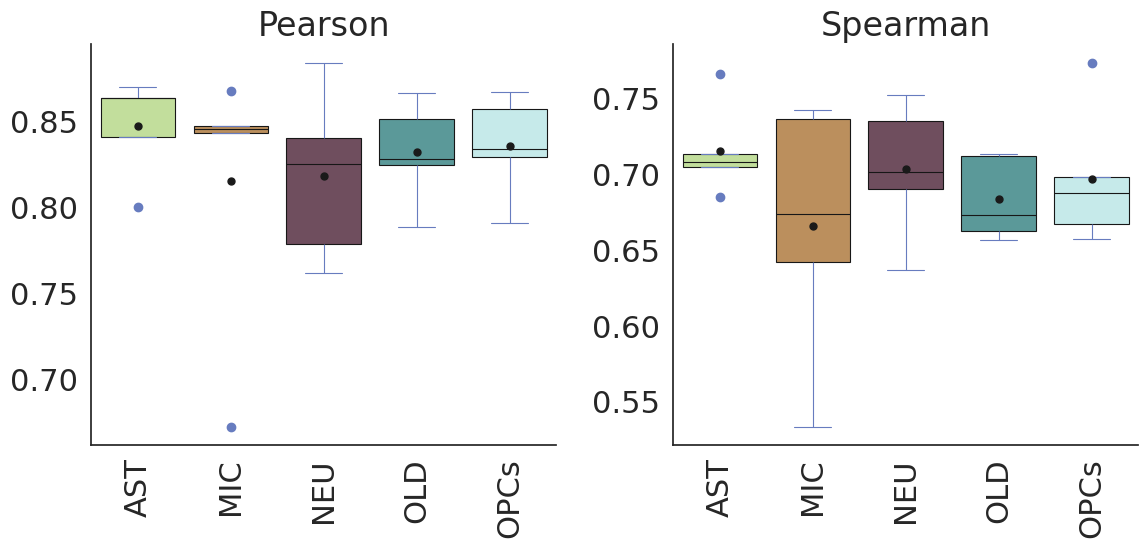

In [45]:
df_metrics["method"] = "Cellformer"
savename = "tmp"
metrics=["pearson", "spearman"]
# metrics= ["auc", "auprc"]
plot_per_celltype(df_metrics,
                  "Cellformer",
                     model_path+"results_deconv_Cellformer" ,
                    metrics,
                    )